In [111]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats   as stats               # for stats.nbinom.logpmf()
import scipy.special as special             # for special.logsumexp()

import pandas as pd

%matplotlib inline

# 1. Reproduce Wiggins' K-means result

First, I load in and convert the data from the .tbl file into a format that we can easily manipulate and perform calculations on (i.e., a numPy array). 

In [112]:
# function by utilizing w09-visualize.py
def read_data(infile):
    '''
    read_data(infile)
    Read Wiggins' input file, w09-data.tbl, or a file in that format.
    Return:
       ctype[0..N-1] : cell types 0..Q-1 for each cell i
       data[i,g]     : array of count data; rows = cells i; cols = genes g
       N             : number of cells (rows of the data file)
       G             : number of genes (cols of the data file, after the first)
       Q             : number of cell types
    '''
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue   # skip comment lines
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( [int(fields[2]), int(fields[3])])  # assumes exactly 2 genes!!
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q

In [113]:
# read in Wiggins' data
data = read_data('w09-data.tbl')

# convert the tuple 'data' into a DataFrame and then to a numPy array for ease of processinng
df = pd.DataFrame(data[1], columns=['defA', 'kilA'])

# save our data about 'defA' and 'kilA' expression into an array called 'df'
df = df.to_numpy()

In [10]:
def initialize_means(X, k):
    """
    Randomly initialize a centroid by selecting randomly from the dataset X.

    Returns:
    - centroid = a random centroid positions
    """

    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    return centroids

In [11]:
def assignment(X, centroids): 
    """
    Perform the assginment step, where we assign each data point X_i to its closest 
    centroid μ_k.
    
    Input:
        coords  : the mapped read counts data for the two genes.
        centers : the current centroid positions.
    Output:
        clusters: the cluster assignments for each data point after assigning each 
                  to the closest centroid.
        distance: the total squared distance for all data points relative to the 
                  respective centroids. 
    """
      
    # for each data point, get all distances relative to each centroid and assign 
    # the data point to the closest centroid/cluster.
    clusters =  [np.argmin([dis.euclidean(i, point) for i in centers]) for point in coords]
    
    # get the distance between each point and its closest centroid.
    distances = [np.min([dis.euclidean(i, point) for i in centers]) for point in coords]
        
    # sum over all distances to get the total squared distance.
    distance = sum(distances)
    
    return clusters, distance

In [12]:
def update(coords, clusters, k):
    """
    Perform the update step, where we calculate the new centroids μ_k.
    
    Input:
        coords  : the mapped read counts data for the two genes.
        clusters: the cluster assignments for each data point.
        k       : the number of clusters.
    Output:
        centers : the updated centroid positions after averaging.s
    """
    coords = np.asarray(coords)
    
    # for each point belonging to a cluster, get the index of that cluster.
    clusters = [np.where(np.asarray(clusters) == i) for i in range(k)]
    
    # for each point belonging to a cluster, get the averaged position of those 
    # points and set them as the new centroids.
    centers = [np.mean(coords[clusters[i]], 0).tolist() for i in range(len(clusters))]
    
    return centers

The first step of the k-means algorithm is to pick $k=5$ initial centroids randomly from the existing data points. Below, the <code>initialize_mean</code> generates a random centroid by sampling a random point from the dataset.

In [13]:
def initialize_mean(X):
    """
    Randomly initialize a centroid by selecting randomly from the dataset X.

    Returns:
    - centroid = a random centroid positions
    """

    centroid = X[np.random.choice(X.shape[0])]

    return centroid

Then, I write a function to calculate the Euclidean distance between two points, which will be used within our k-means algorithm:
$$d(p,q) = \sqrt {\sum_{i=1}^n (q_i - p_i)^2}$$
where:
- $p, q$ = two points in Euclidean n-space
- $q_i, p_i$ = Euclidean vectors, starting from the origin of the space (initial point)
- $n$ = $n$-space

In [14]:
def euclidean_dist(p1, p2):
    """
    Parameters:
    - p1: point 1
    - p2: point 2
    
    Returns: euclidean distance between two points
    """
    d = 0
    for i in range(len(p1)):
        # distance formula
        d += (p1[i] - p2[i])**2

    d = np.sqrt(d)
    return d

Using the <code>euclidean_dist</code> function, we can write a function to identify the closest centroid for each data point. This function iterates through the list of centroids generated in the initialization step and calculates the distance between the given centroid and the given data point, x.

In [15]:
# identify the closest centroid for each data point using calculated euclidean distance
# assign that data point to that centroid
def closest_centroid(x, centroids):
    """
    Parameters:
    - centroids: current centroid positions as generated by intialize_means
    - x: one data point
    
    Returns:
    - best_k: index of the best centroid (for x)
    - best_d: distance to the best centroid (for x)
    """

    # K = number of centroids; in this problem set, k = 5
    K = centroids.shape[0]
    
    # set the "best cluster" to the first cluster, or cluster 0 
    best_cluster = 0
    
    # set the "best distance" to the distance between the data point and the first centroid (centroid of cluster 0)
    best_dist = euclidean_dist(x, centroids[0])
   
    # iterate through the list of centroids starting from the second centroid
    
    for k in range(1, K):
        # perform distance calculations for each of the centroids and data points to find the closest one
        dist = euclidean_dist(x, centroids[k])
        # minimize the distance between the data point and the centroid
        if dist < best_dist:
            # set the cluster index as best_cluster for this particular centroid
            best_cluster = k
            # record the distance between the best_cluster cluster and the current data point
            best_dist = dist
    
    return best_cluster, best_dist

Here, we utilize the <code>closest_centroid</code> function within the <code>assign_kmeans</code> to assign each data point to a cluster $k$. 

In [16]:
# here, we actually implement the k-means assignment
def assign_kmeans(X, centroids):
    """
    Inputs:
    - centroids: list of centroid positions as generated by intialize_means
    - X: the data 
   
    Returns:
    - assignments: list that records the assignment of each data point i to cluster k (from 0-4)
    - tot_sqdist: total squared distance (k-means objective function)
    """
    
    # K = number of centroids
    K = centroids.shape[0]

    # number of points
    N = len(X)
    
    # initialize a N x 1 array of zeros to store the assignment of points to a centroid
    assignments = np.zeros(N).astype(int)

    # initialize the total square distance measure
    tot_sqdist = 0
    
    # assigning actual centroid/cluster identity and adding to total square distance 
    # i: index of a point
    # x: the actual data point
    for i, x in enumerate(X):
        # assignment of data point is stored in assignments[i]
        assignments[i], dist = closest_centroid(x, centroids)
        
        # total squared distance
        tot_sqdist += dist ** 2
    
    return assignments, tot_sqdist

In [17]:
# k-means update step to calculate new centroid positions, given assignments of data points
# need to avoid empty centroids or outliers (force convergence)
def update_kmeans(X, assignments, K):
    """
    Inputs:
    - X: the data 
    - assignments: assignment of each data point i (represented as assignment[i]) to cluster k
    - K: number of centroids/clusters
    
    Returns:
    - Updated centroid positions
    - counts[k] = frequency of using component k (aka how many points were assigned to it, normalized)
    """

    # N: number of cells (rows of the data file)
    # G: number of genes (cols of the data file, after the first)
    N, G = X.shape            
    centroids = np.zeros((K,G))
    counts = np.zeros(K)

    # iterate through each cell
    for i in range(N):
        counts[assignments[i]] += 1
        for g in range(G):
            # iterate through each gene (2 genes)
            centroids[assignments[i], g] += X[i][g]
    
    for k in range(K):
        # if a centroid is not empty, we recalculate the position of the centroid by averaging over the number of points in it
        if counts[k] > 0:                                      
            centroids[k] = centroids[k] / counts[k]
        # if the centroid is empty, we reinitialize it randomly
        else:                                                  
            centroids[k] = initialize_mean(X)

    Z = np.sum(counts)
    counts = np.divide(counts, Z)
    
    return centroids, counts

In [18]:
# checking whether iterative algorithm has converged by seeing if any cluster assignments differ
def diff_assignments(a1, a2):
    """
    Parameters:
    - a1: initial assignments of data points
    - a2: updated assignments of data points
    
    Output:
        ndiff = number of assignments that differ between a1 and a2
    """
    
    N = len(a1)
    ndiff = 0
    
    for i in range(N):
        if a1[i] != a2[i]: 
            ndiff += 1
            
    return ndiff

In [19]:
def kmeans(X, k):
    """
    Parameters:
    - X: dataset
    - k: how many clusters to fit
    
    Returns:
    - 
    """
    
    N, G = np.shape(X)
    
    centroids = np.zeros((K,G))
    for k in range(K):
        centroids[k] = initialize_mean(X)
    
    # checking for convergence and looping through until ndiff = 0 is reached
    iteration = 0
    while True:
        assignments, tot_sqdist = assign_kmeans(X, centroids)

        if iteration >= 1:
            ndiff = diff_assignments(assignments, old_assignments)
            if ndiff == 0:
                break
        centroids, kp = update_kmeans(X, assignments, K)
        old_assignments = assignments
        iteration      += 1
    
    print("iterations = {}".format(iteration))

    # normalization step
    kp = np.zeros(K)
    for i in range(N):
        kp[assignments[i]] += 1
    
    kp = np.divide(kp, N)

    return kp, centroids, assignments, tot_sqdist

In [77]:
# function from w09-visualize.py
def visualize_data(data, mu, C, outpng):
    '''
    visualize_data():

    This might give you a starting point that saves some matplotlib
    machinations; you can certainly spiff this up from here.

    Input:
       data[i,g] : count data for each cell i, for each gene g 
       mu[q,g]   : array of mean counts for mixture q, gene g --> final list of centroids that you get from k-means (np array of 2D points)
       C[i]      : assignment of cell i to a cluster 0..Q-1 -> how our k-means assigns the cell, list of length N, with 0, 1, 2, 3, or 4
       outpng    : save figure to PNG file (must end in .png; example 'foo.png')

    '''
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    genes = [ 'defA', 'kilA' ]

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(mu[q,0], mu[q,1], '*k', ms=10)

    ax.set_xlabel('{} (counts)'.format(genes[0]))
    ax.set_ylabel('{} (counts)'.format(genes[1]))

    fig.savefig(outpng)

iterations = 21
RNG seed  0:  tot_sqdist     975975.8

iterations = 13
RNG seed  1:  tot_sqdist     983007.9

iterations = 15
RNG seed  2:  tot_sqdist     976092.3

iterations = 41
RNG seed  3:  tot_sqdist     975899.8

iterations = 34
RNG seed  4:  tot_sqdist     975899.8

iterations = 48
RNG seed  5:  tot_sqdist     975899.8

iterations = 18
RNG seed  6:  tot_sqdist     985369.0

iterations = 50
RNG seed  7:  tot_sqdist     975899.8

iterations = 22
RNG seed  8:  tot_sqdist     985376.4

iterations = 19
RNG seed  9:  tot_sqdist     983833.2

iterations = 17
RNG seed 10:  tot_sqdist     976092.3

iterations = 17
RNG seed 11:  tot_sqdist     985236.4

iterations = 14
RNG seed 12:  tot_sqdist     987790.6

iterations = 15
RNG seed 13:  tot_sqdist     987440.2

iterations = 27
RNG seed 14:  tot_sqdist     985236.4

iterations = 10
RNG seed 15:  tot_sqdist     976092.3

iterations = 11
RNG seed 16:  tot_sqdist     983007.5

iterations = 10
RNG seed 17:  tot_sqdist     982794.7

iterations

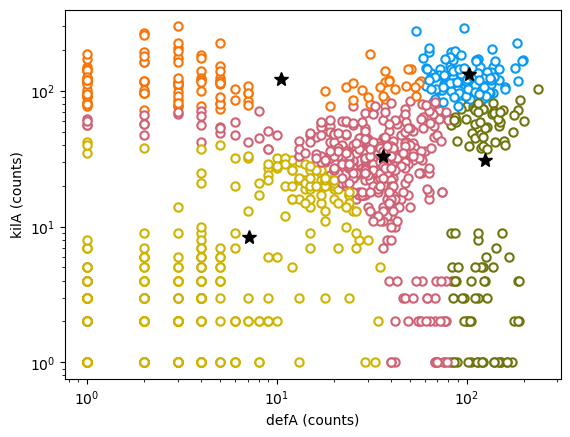

In [21]:
K = 5
best_totdist = 1000000000000
best_run = 0
best_centroids = None
best_assignments = None

# selecting the best of 20 solutions, as Wiggins did
for run in range(20):
    np.random.seed(run)
    kp, centroids, assignments, tot_sqdist = kmeans(df, K)
    print("RNG seed {0:2d}:  tot_sqdist {1:12.1f}\n".format(run, tot_sqdist))
    
    if tot_sqdist < best_totdist:
        best_totdist = tot_sqdist
        best_run = run
        best_centroids = centroids
        best_assignments = assignments

# Plotting only the best run
visualize_data(df, best_centroids, best_assignments, "best_run_vis.png")

**Interpretation:** A good statistic for choosing the "best" solution for K-means is to pick the 'tot_sqdist' measure that is the smallest, after running the k-means algorithm until it converges to a solution (until points are not reassigned). 

The actual clusters do not have the same number of data points in them, because the data is dominating over the prior. One assumption of k-means is that we have the same # of data points in each cluster, but the data violates this.

Based on the above plot and total squared distance, we were able to reproduce Wiggins' "bad" clustering results. As the PSET says, this is likely due to the fact that k-means is prone to local minima, since. We are assuming that the data is drawn from a Gaussian distribution in our k-means algorithm, hence our poorly clustered cells. 

# 2. Mixture negative binomial fitting

Write an expectation maximization algorithm to fit a mixture negative binomial distribution to Wiggins' data, for Q=5 components in the mixture. Assume there is a common dispersion $\phi = 0.2$.

#### 1) Expectation

In this step, we aim to determine the probability that each data point $X_i$ belongs to each cluster $q$, given the current model parameters. This probability can be written as $P(q \mid X_i)$, following the Bayesian structure $P(\text{hypothesis} \mid \text{data})$. 

$$
P(q \mid X_i, n, p) = \frac{P(X_i, q \mid n, p)}{\sum_{q} P(X_i, q \mid  n, p)}
$$

This joint probability factors due to independence assumptions: selecting a component distributed Negative Binomial is independent of selecting a data point from that component. Thus,

$$
P(X_i, q \mid  n, p) = P(X_i \mid q,  n, p) P(q \mid p)
$$


Negative binomial distribution models the number of failures in a sequence of i.i.d. Bernoulli trials (with success rate p) before n successes occur. Let $X$ be the number of failures, $X$ ~ NB$(np,p)$.

During this step, we calculate the posterior probability for each cell $X_i$ coming from each cluster $q$, which is given by
/
$$P(X = k | n,p) = {k + n - 1 \choose n-1} (1-p)^k p^n$$

Using the joint probability and the negative binomial distribution, we can rewrite the posterior probability as:
$$
P(q \mid  X_i, n, p)  = \frac {\pi_q P(X_i \mid  q, n, p)}{\sum \pi_q P(X_i \mid  q, n, p) }
$$

Additionally, we also have $n=\frac{1}{\phi}, p = \frac{1}{1+\mu_q * \phi}$, so we can substitute this in to our <code>stats.nbinom.logpmf(x,n,p)</code> function as parameters.

In [125]:
def expectation(X, centroids, mix_coeffs, phi=0.2):
    """
    Return the posterior probability of each data point X_i coming from each cluster 
    and current cluster assignment for each point X_i.
    
    Input:
    - X: dataset, the mapped reads of the two genes in 2D array form
    - centroids: the centroids
    - mix_coeffs: the mixture coefficients for each component in 2D array form
    
    Returns:
    - posteriors: the log-posterior probabilities that each data point comes from each cluster, an NxQ array
    - clusters: the cluster assignment for each data point X_i

    """

    # N = 1000
    # G = 2
    N, G = X.shape

    # Q = 5
    Q = len(centroids)
    
    # initialize all parameters to be calculated as numpy arrays
    posteriors = np.zeros((N, Q))

    # initialize n, since it is a constant
    n = 1/phi
    
    # calculate the log-probability for each data point
    for i in range(Q):
        for j in range(len(centroids[i])):
            # update p for this data point and this centroid
            p = 1/(1+centroids[i, j]*phi)
            posteriors[:, i] += stats.nbinom.logpmf(X[:, j], n, p)
    posteriors += np.log(mix_coeffs)
    
    # normalize log-probability to get the posterior probability
    posteriors -= special.logsumexp(posteriors, axis=1)[:, np.newaxis]

    # assign each point to a cluster based on the maximum posterior probability
    clusters = [np.argmax(posteriors[i]) for i in range(N)]
    
    return posteriors, clusters

Below is our maximization step. During this step, we update the centroids $\mu$ and mixture coefficients $\pi_q$ given the posterior probabilities.

The new centroid for each component $q$ is calculated as the posterior-weighted average of point positions, given by:
$$
\mu_q = \frac{\sum_i P(q \mid X_i) X_i}{\sum_i P(q \mid X_i)}
$$

The new mixture coefficient for each component is calculated as the mean of the posteriors for that component, given by:
$$
\pi_q = \frac{\sum_i P(q \mid X_i)}{N}
$$
where $N$ represents the total number of data points.


In [121]:
def maximization(X, posteriors, mix_coeffs):
    """
    Return the updated mu and mixture coefficient for each component.
    
    Parameters:
    - X: 2D array, coordinates of all points
    - posteriors: 2D array, Posterior probabilities of each component being the source of each point
    - mix_coeffs: the mixture coefficients for each component in 2D array form
    
    Returns:
    -------
    - centroids: 2D array, updated component means
    - mix_coeffs: 2D array, updated estimates for mixture coefficients of components 
    """
    
    N, G = X.shape
    Q = len(mix_coeffs)
    
    # initialize all parameters as numpy arrays
    numerator = np.zeros((Q, G))
    denominator = np.zeros((Q, G))
    new_data = np.zeros((G, N))
    new_posteriors = np.zeros((G, N))
    
    # calculate the numerator of the weighted means
    for i in range(Q):
        for j in range(N):
            for k in range(len(X[j])):
                new_data[k, j] = posteriors[j, i] + np.log(X[j, k])
                numerator[i, k] = special.logsumexp(new_data[k])

    # calculate the denominator of the weighted means
    for i in range(Q):
        for j in range(N):
            for k in range(len(X[j])):
                new_posteriors[k, j] = posteriors[j, i]
                denominator[i, k] = special.logsumexp(new_posteriors[k])


    # calculated the weighted means (numerator/denominator)
    centroids = np.exp(numerator - denominator)

    # calculate the new mixture coefficients as the mean of the posteriors
    for i in range(len(centroids)):
        mix_coeffs[i] = np.sum(denominator[i])
    mix_coeffs = mix_coeffs/N
    
    return centroids, mix_coeffs

Calculate the negative log-likelihood of the model as a metric for determining the best "fit". This is how we will determine which of our initial conditions is the best one (using our EM algorithm).

In [122]:
def negll(X, centroids, mix_coeffs, phi=0.2):
    """
    Calculates the negative log-likelihood of data given the current mixture model.
    
    Input:
    - X: 2D array, coordinates of all points
    - mix_coeffs: the mixture coefficients for each component in 2D array form
    - centroids: the centroids
        
    Returns: 
    - nll: the negative log likelihood of data given model
    """
    
    N, G = X.shape
    Q = len(centroids)

    # pre-compute n, constant
    n = 1/phi

    log_prob = np.zeros(Q)
    log_likelihood = np.zeros(N)

    # calculate the negative log-likelihood as the log-probability mass function 
    # of the data, plus the log-mixture coefficient (in probability space, this would be a product) 
    for i in range(Q):
        for j in range(len(centroids[i])):
            p = 1/(1+centroids[i, j]*phi)
            log_prob[i] += stats.nbinom.logpmf(X[i, j], n, p)
    log_prob += np.log(mix_coeffs)

    for i in range(N): 
        log_likelihood[i] = special.logsumexp(log_prob)
        
    # calculate the negative log-likelihood
    nll = -np.sum(log_likelihood)
     
    return nll

Finally, we run our EM algorithm with $\phi=0.2$ and an arbitrary likelihood for our negative log likelihood, 0.0005. We will once again run it for 20 iterations to determine the best fit.

In [127]:
def em_algo(X, k = 5, runs = 20, phi = 0.2, nll_threshold = 0.0005):
    """
    The EM clustering algorithm.
    
    Input:
    - X: 2D array, coordinates of all points
    - k=5: the number of clusters
    - nll_threshold: an threshold to determine convergence
    
    Returns:
    - best_clusters: the best cluster assignments for each data point based on the iteration with minimial log-likelihood
    - best_centroids : the best centroid positions for based on the iteration with minimial log-likelihood
    """
    
    # N = 1000, G = 2
    N, G = X.shape
    
    # initialize all parameters to be updated
    best_centroids = []* N
    nll_best = np.inf

    for run in range(runs):
        
        # initialize a random set of centroids, initialize mixture coeffcients equally for each iteration
        mix_coeffs = np.full(k, 1 / k)
        mix_coeffs = mix_coeffs / np.sum(mix_coeffs)
        centroids = X[np.random.choice(X.shape[0], k, replace = False)]

        # initialize variables for the negative log likelihood, which will be updated at each iteration
        nll_diff = np.inf
        nll_old = 0.0

        # iterate until the difference between consecutive negative log-likelihoods are above the set threshold
        while nll_diff > (nll_threshold*nll_old):

            # calculate the posterior probabilities and assign data points to their clusters
            posteriors, clusters = expectation(X, centroids, mix_coeffs)

            # calculate the new centroids and mixture coefficients given the calculated posterior probability matrix
            centroids, mix_coeffs = maximization(X, posteriors, mix_coeffs)    

            # calculate the negative log-likelihood of the current negative binomial mixture model
            nll = negll(X, centroids, mix_coeffs)
            nll_diff = abs(nll-nll_old)
            nll_old = nll
            
        # update the best estimates for the centroid positions, mixture coefficients, and cluster assignments
        # based on negative log likelihoood -> our goal is to go with the iteration with the smallest log likelihood
        if nll < nll_best:
            nll_best = nll
            best_centroids = centroids
            best_clusters = clusters
            
    return best_clusters, best_centroids

As expected, we can see that this method of clustering more accurately clusters the data into the five different cell types. The clustering in this algorithm is based on the iteration that produces the smallest negative log likelihood; each iteration updates the centroids and mixture coefficients (weights) of the negative binomial model.

In [ ]:
# Run the EM algorithm
em_best_clusters, em_best_centroids = em_algo(df)
visualize_data(df, em_best_centroids, em_best_clusters, 'em.png')

**Question:** What are the estimated mean expression levels of defA and kilA in the five cell types, and the relative proportions of each cell type in the 1000 cells?

In [ ]:
# calculate the estimated mean expression levels for each of the five cell types and the relative proportions of each cell type
stats_df = pd.DataFrame(df, columns=['defA', 'kilA'])
stats_df['cluster'] = em_best_clusters

# calculate the mean values and fraction
results = stats_df.groupby('cluster').agg(
    defA_mean=('defA', 'mean'),
    kilA_mean=('kilA', 'mean'),
    fraction=('cluster', 'size')
)

# Convert the cluster counts to fractions
results['fraction'] = results['fraction'] / len(stats_df)
results

# 3. Find a simple fix for K-means
Suggest a simple fix for the problem in applying a standard K-means clustering algorithm to Wiggins' single cell RNA-seq data. Implement the fix, re-run the K-means clustering, pick a "best" solution; report and visualize it.

We noticed that the actual clusters don't have the same number of data points in them because the data is dominating over the prior. One of the assumptions of k-means is that we have the same number of data points in each cluster; however, this assumption is not enforced in the data. We cannot set specific numbers to a cluster; thus, we have to "do something" to the data before running k-means. 

The simple fix turns out to be converting everything into log-space, as we do below. Transforming our read counts will fit with how our k-means algorithm assumes that the data is drawn from a Gaussian distribution. Therefore, we can assume much better results as compared to part 1, and results on par with our EM algorithm from part 2.

In [70]:
# redfine the visualization function in order to plot in logspace
def revisualize_data(data, mu, C, log_scale=False, log_labs=False):
    '''
    visualize_data():

    This might give you a starting point that saves some matplotlib
    machinations; you can certainly spiff this up from here.

    Input:
       data[i,g] : count data for each cell i, for each gene g
       mu[q,g]   : array of mean counts for mixture q, gene g
       C[i]      : assignment of cell i to a cluster 0..Q-1
       outpng    : save figure to PNG file (must end in .png; example 'foo.png')

    '''
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    genes = [ 'defA', 'kilA' ]

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()

    # modify the code here to include a log_scale for revisualization
    if log_scale == True:
        for i in range(N):
            edgecolor = colormap[C[i]]
            fillcolor = 'w'
            shape     = 'o'
            ax.plot(data[i,0], data[i,1], marker = shape, mec = edgecolor, mfc = fillcolor, mew = 1.5)

        for q in range(Q):
            ax.plot(mu[q,0], mu[q,1], '*k', ms = 10)
    else:
        for i in range(N):
            edgecolor = colormap[C[i]]
            fillcolor = 'w'
            shape     = 'o'
            ax.loglog(data[i,0], data[i,1], marker = shape, mec = edgecolor, mfc = fillcolor, mew = 1.5)

        for q in range(Q):
            ax.loglog(mu[q,0], mu[q,1], '*k', ms = 10)

    ax.set_xlabel('{} (counts)'.format(genes[0]))
    ax.set_ylabel('{} (counts)'.format(genes[1]))

iterations = 18
RNG seed  0:  tot_sqdist        888.0

iterations = 14
RNG seed  1:  tot_sqdist        893.0

iterations = 7
RNG seed  2:  tot_sqdist        583.1

iterations = 7
RNG seed  3:  tot_sqdist        583.1

iterations = 6
RNG seed  4:  tot_sqdist        583.1

iterations = 8
RNG seed  5:  tot_sqdist        910.1

iterations = 19
RNG seed  6:  tot_sqdist        886.3

iterations = 10
RNG seed  7:  tot_sqdist        583.1

iterations = 6
RNG seed  8:  tot_sqdist        583.1

iterations = 6
RNG seed  9:  tot_sqdist        583.1

iterations = 16
RNG seed 10:  tot_sqdist        888.4

iterations = 6
RNG seed 11:  tot_sqdist        583.1

iterations = 7
RNG seed 12:  tot_sqdist        583.1

iterations = 5
RNG seed 13:  tot_sqdist        583.1

iterations = 7
RNG seed 14:  tot_sqdist        583.1

iterations = 12
RNG seed 15:  tot_sqdist        583.1

iterations = 14
RNG seed 16:  tot_sqdist        583.1

iterations = 6
RNG seed 17:  tot_sqdist        583.1

iterations = 5
RNG se

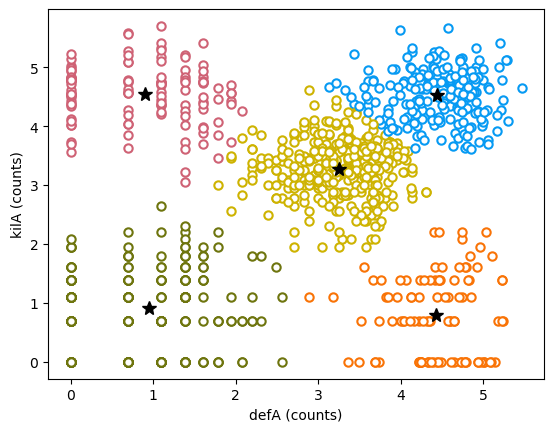

In [71]:
# re-run K-means clustering, pick a best solution, and visualize it
K = 5
best_totdist = 1000000000000
best_run = 0
best_centroids = None
best_assignments = None

# selecting the best of 20 solutions, as Wiggins did
for run in range(20):
    np.random.seed(run)
    kp, centroids, assignments, tot_sqdist = kmeans(np.log(df), K)
    print("RNG seed {0:2d}:  tot_sqdist {1:12.1f}\n".format(run, tot_sqdist))
    
    if tot_sqdist < best_totdist:
        best_totdist = tot_sqdist
        best_run = run
        best_centroids = centroids
        best_assignments = assignments

# Plotting only the best run
revisualize_data(np.log(df), best_centroids, best_assignments, log_scale=True, log_labs=True)

In [72]:
%load_ext watermark
%watermark -v -m -p jupyter,numpy,matplotlib

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

jupyter   : 1.1.1
numpy     : 2.1.1
matplotlib: 3.9.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

